# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [892]:
from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis)


from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4)

#%matplotlib notebook
%matplotlib inline

In [893]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [894]:
#%%javascript
#var nb = IPython.notebook;
#var kernel = IPython.notebook.kernel;
#var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
#kernel.execute(command);

In [895]:
#print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

## Make a directory for saving results

In [896]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "commissioning"

username = "zhangz"

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/zhangz/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [897]:
# 50ms dose
uid_=  'PEO430k_AuNP20nm_25nM_Capillary_RT'
start_time, stop_time = '2016-11-10  21:16:59', '2016-11-10  21:20:08' #4ms --> 0.4s , 110 frames

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_RT'
start_time, stop_time = '2016-11-10  21:20:09', '2016-11-10  21:23:15' #40ms --> 4s , 110 frames

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_RT'
start_time, stop_time = '2016-11-10  21:23:16', '2016-11-10  21:33:52' #0.5s --> 50s , 110 frames

uid_= 'dose_test'
start_time, stop_time = '2016-11-10  21:53:19', '2016-11-10  21:54:37'

# 12.5ms dose
uid_=  'PEO430k_AuNP20nm_25nM_Capillary_RT'
start_time, stop_time = '2016-11-10  22:05:03', '2016-11-10  22:07:37' #4ms --> 0.4s , 110 frames
start_time, stop_time = '2016-11-10  22:07:38', '2016-11-10  22:10:18' #40ms --> 4s , 110 frames
start_time, stop_time = '2016-11-10  22:10:19', '2016-11-10  22:17:59' #0.5s --> 50s , 110 frames

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_70C'
start_time, stop_time = '2016-11-11  00:08:08', '2016-11-11  00:10:16 ' #4ms --> 0.4s , 110 frames
start_time, stop_time = '2016-11-11  00:10:16', '2016-11-11  00:12:31 ' #40ms --> 4s , 110 frames
start_time, stop_time = '2016-11-11  00:12:32', '2016-11-11  00:22:50 ' #0.5s --> 50s , 110 frames

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_85C'
start_time, stop_time = '2016-11-11  01:02:02', '2016-11-11  01:04:21 ' #4ms --> 0.4s , 110 frames
start_time, stop_time = '2016-11-11  01:04:22', '2016-11-11  01:06:37 ' #40ms --> 4s , 110 frames
start_time, stop_time = '2016-11-11  01:06:37', '2016-11-11  01:17:02 ' #0.5s --> 50s , 110 frames
bad_list = []

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_120C'
start_time, stop_time = '2016-11-11  02:02:36', '2016-11-11  02:04:48 ' #4ms --> 0.4s , 110 frames
start_time, stop_time = '2016-11-11  02:04:49', '2016-11-11  02:07:02 ' #40ms --> 4s , 110 frames
start_time, stop_time = '2016-11-11  02:07:03', '2016-11-11  02:17:24 ' #0.5s --> 50s , 110 frames
bad_list = []

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_160C'
start_time, stop_time = '2016-11-11  05:06:36', '2016-11-11  05:08:48 ' #4ms --> 0.4s , 110 frames
start_time, stop_time = '2016-11-11  05:08:49', '2016-11-11  05:11:06 ' #40ms --> 4s , 110 frames
start_time, stop_time = '2016-11-11  05:11:06', '2016-11-11  05:21:24 ' #0.5s --> 50s , 110 frames
bad_list = []

uid_=  'PEO39k_AuNP20nm_25nM_Capillary_RT_doseTEST'
start_time, stop_time = '2016-11-11  12:15:38', '2016-11-11  12:16:17 ' #0.01s * 1s
start_time, stop_time = '2016-11-11  12:26:15', '2016-11-11  12:28:05 ' #0.2s * 20s
bad_list = []

uid_=  'PEO39k_AuNP20nm_25nM_Capillary_40C'
start_time, stop_time = '2016-11-11  12:41:06', '2016-11-11  12:43:34 ' #20ms --> 2s , 110 frames
start_time, stop_time = '2016-11-11  12:43:34', '2016-11-11  12:45:52 ' #2ms --> 0.2s , 110 frames
start_time, stop_time = '2016-11-11  12:45:53', '2016-11-11  12:56:16 ' #0.5s --> 50s , 110 frames

uid_=  'PEO39k_AuNP20nm_25nM_Capillary_85C'
start_time, stop_time = '2016-11-11  14:06:24', '2016-11-11  14:08:49 ' #20ms --> 2s , 110 frames
start_time, stop_time = '2016-11-11  14:08:50', '2016-11-11  14:11:02 ' #2ms --> 0.2s , 110 frames
start_time, stop_time = '2016-11-11  14:11:02', '2016-11-11  14:21:24 ' #0.5s --> 50s , 110 frames

uid_=  'PEO39k_AuNP20nm_25nM_Capillary_120C'
start_time, stop_time = '2016-11-11  15:09:16', '2016-11-11  15:11:42 ' #20ms --> 2s , 110 frames
start_time, stop_time = '2016-11-11  15:11:43', '2016-11-11  15:13:57 ' #2ms --> 0.2s , 110 frames
start_time, stop_time = '2016-11-11  15:13:58', '2016-11-11  15:24:23 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO39k_AuNP20nm_25nM_Capillary_160C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-11  16:24:29', '2016-11-11  16:27:57 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-11  16:27:57', '2016-11-11  16:31:05 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-11  16:31:06', '2016-11-11  16:42:16 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO39k_AuNP20nm_25nM_Capillary_180C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-11  17:22:30', '2016-11-11  17:25:36 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-11  17:25:37', '2016-11-11  17:28:32 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-11  17:28:33', '2016-11-11  17:39:43 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO1p1k_AuNP20nm_25nM_Capillary_50C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-11  19:55:59', '2016-11-11  19:59:07 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-11  19:59:08', '2016-11-11  20:02:09 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-11  17:28:33', '2016-11-11  17:39:43 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO1p1k_AuNP20nm_25nM_Capillary_85C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-11  20:57:12', '2016-11-11  21:00:27 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-11  21:00:28', '2016-11-11  21:03:26 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-11  21:03:27', '2016-11-11  21:14:43 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO1p1k_AuNP20nm_25nM_Capillary_120C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-11  22:01:49', '2016-11-11  22:05:24 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-11  22:05:25', '2016-11-11  22:08:45 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-11  22:08:46', '2016-11-11  22:20:32 ' #.5s --> 50s, 110 frames


# GTSAXS
measurement_ = 'PEO39k_AuNP20nm_25nM_Dropcast_RT'
uid_=  measurement_+'_doseTEST'
start_time, stop_time = '2016-11-12  11:46:56', '2016-11-12  11:49:01 '
start_time, stop_time = '2016-11-12  11:53:59', '2016-11-12  11:55:58 '
start_time, stop_time = '2016-11-12  12:03:43', '2016-11-12  12:05:45 ' 


measurement_ = 'PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_37C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-12  12:12:42', '2016-11-12  12:16:15 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-12  12:16:16', '2016-11-12  12:19:32 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-12  12:19:33', '2016-11-12  12:31:00 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO430k_AuNP20nm_25nM_Dropcast_RT'
uid_=  measurement_+'_doseTEST'
start_time, stop_time = '2016-11-12  13:21:13', '2016-11-12  13:23:14'
start_time, stop_time = '2016-11-12  13:32:08', '2016-11-12  13:34:13'

measurement_ = 'PEO430k_AuNP20nm_25nM_Dropcast_GTSAXS_37C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-12  13:43:15', '2016-11-12  13:47:08 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-12  13:47:09', '2016-11-12  13:50:43 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-12  13:52:07', '2016-11-12  14:04:43 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO430k_AuNP20nm_25nM_Dropcast_GTSAXS_85C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-12  15:46:30', '2016-11-12  15:50:56 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-12  15:50:56', '2016-11-12  15:55:09 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-12  15:55:10', '2016-11-12  16:07:45 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_85C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-12  16:17:02', '2016-11-12  16:21:35 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-12  16:21:36', '2016-11-12  16:25:57 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-12  16:25:58', '2016-11-12  16:38:26 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO430k_AuNP20nm_25nM_Dropcast_GTSAXS_85C rerun at higher dose'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-12  16:49:31', '2016-11-12  16:53:59 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-12  16:54:00', '2016-11-12  16:58:02 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-12  16:58:02', '2016-11-12  17:10:29 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO430k_AuNP20nm_25nM_Dropcast_GTSAXS_100C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-12  17:37:45', '2016-11-12  17:40:55 ' #20ms --> 2s , 110 frames
uid_=  measurement_+'_Run2'
start_time, stop_time = '2016-11-12  18:40:00', '2016-11-12  18:43:56 ' #2ms --> 0.2s , 110 frames
uid_=  measurement_+'_Run3'
start_time, stop_time = '2016-11-12  18:43:57', '2016-11-12  18:55:46 ' #.5s --> 50s, 110 frames

measurement_ = 'PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C'
uid_=  measurement_+'_Run1'
start_time, stop_time = '2016-11-12  19:03:13', '2016-11-12  19:07:12 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-12  19:07:12', '2016-11-12  19:10:51 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-12  19:10:51', '2016-11-12  19:22:44 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_120C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-12  19:51:53', '2016-11-12  19:56:21 ' #20ms --> 2s , 110 frames
# # uid_=  measurement_+'_Run2'
# # start_time, stop_time = '2016-11-12  19:56:22', '2016-11-12  20:00:43 ' #2ms --> 0.2s , 110 frames
# # uid_=  measurement_+'_Run3'
# # start_time, stop_time = '2016-11-12  20:00:43', '2016-11-12  20:13:20 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO430k_AuNP20nm_25nM_Dropcast_GTSAXS_120C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-12  20:17:41', '2016-11-12  20:22:11 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-12  20:22:11', '2016-11-12  20:26:25 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-12  20:26:26', '2016-11-12  20:38:46 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO430k_AuNP20nm_25nM_Dropcast_GTSAXS_160C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-12  21:40:21', '2016-11-12  21:44:55 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-12  21:44:56', '2016-11-12  21:49:17 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-12  21:49:18', '2016-11-12  22:01:52 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_160C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-12  22:16:42', '2016-11-12  22:21:17 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-12  22:21:17', '2016-11-12  22:25:53 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-12  22:25:54', '2016-11-12  22:38:22 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO4k_AuNP20nm_25nM_Dropcast_GTSAXS_40C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  00:52:05', '2016-11-13  00:57:04 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  00:57:04', '2016-11-13  01:01:44 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-13  01:01:44', '2016-11-13  01:14:09 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO1k_AuNP20nm_25nM_Dropcast_GTSAXS_40C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  01:52:26', '2016-11-13  01:56:15 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  01:56:15', '2016-11-13  02:00:52 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-13  02:00:53', '2016-11-13  02:14:11 ' #.5s --> 50s, 110 frames

# #On Olog this is mistakenly logged as PEO39k
# measurement_ = 'PEO430kLiTFSI0p85_AuNP20nm_25nM_Dropcast_GTSAXS_40C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  02:33:17', '2016-11-13  02:37:59 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  02:38:00', '2016-11-13  02:42:40 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-13  02:00:53', '2016-11-13  02:14:11 ' #.5s --> 50s, 110 frames

# #On Olog this is mistakenly logged as PEO39k
# measurement_ = 'PEO39kLiTFSI0p85_AuNP20nm_25nM_Dropcast_GTSAXS_40C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  10:32:08', '2016-11-13  10:36:14 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  10:36:15', '2016-11-13  10:40:33 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-13  10:40:33', '2016-11-13  10:52:28 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO39kLiTFSI0p85_AuNP20nm_25nM_Dropcast_GTSAXS_85C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  11:50:21', '2016-11-13  11:54:22 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  11:54:23', '2016-11-13  11:58:12 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-13  11:58:13', '2016-11-13  12:10:35 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO1p1k_AuNP20nm_25nM_Dropcast_GTSAXS_85C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  12:15:14', '2016-11-13  12:20:10 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  12:20:10', '2016-11-13  12:25:13 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-13  12:25:14', '2016-11-13  12:38:19 ' #.5s --> 50s, 110 frames

# # Scrapped. Garbage data.
# # measurement_ = 'PEO4k_AuNP20nm_25nM_Dropcast_GTSAXS_85C'
# # uid_=  measurement_+'_Run1'
# # start_time, stop_time = '2016-11-13  12:49:54', '2016-11-13  12:53:56 ' #20ms --> 2s , 110 frames
# # uid_=  measurement_+'_Run2'
# # start_time, stop_time = '2016-11-13  12:53:57', '2016-11-13  12:57:48 ' #2ms --> 0.2s , 110 frames
# # uid_=  measurement_+'_Run3'
# # start_time, stop_time = '2016-11-13  12:57:49', '2016-11-13  --:--:-- ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO4k_AuNP20nm_25nM_Dropcast_GTSAXS_85C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  13:09:38', '2016-11-13  13:13:57 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  13:13:58', '2016-11-13  13:18:27 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-13  13:18:28', '2016-11-13  13:31:21 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO4k_AuNP20nm_25nM_Dropcast_GTSAXS_120C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  14:07:00', '2016-11-13  14:11:58 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  14:11:59', '2016-11-13  14:16:51 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-13  14:16:52', '2016-11-13  14:29:52 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO39kLiTFSI0p85_AuNP20nm_25nM_Dropcast_GTSAXS_120C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  14:40:03', '2016-11-13  14:45:11 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  14:45:12', '2016-11-13  14:50:02 ' #2ms --> 0.2s , 110 frames
# # uid_=  measurement_+'_Run3'
# # start_time, stop_time = '2016-11-13  14:50:03', '2016-11-13  15:03:22 ' #.5s --> 50s, 110 frames

# # measurement_ = 'PEO1p1k_AuNP20nm_25nM_Dropcast_GTSAXS_120C'
# # uid_=  measurement_+'_Run1'
# # start_time, stop_time = '2016-11-13  15:08:12', '2016-11-13  15:13:18 ' #20ms --> 2s , 110 frames
# # uid_=  measurement_+'_Run2'
# # start_time, stop_time = '2016-11-13  15:13:19', '2016-11-13  15:18:10 ' #2ms --> 0.2s , 110 frames
# # uid_=  measurement_+'_Run3'
# # start_time, stop_time = '2016-11-13  15:18:11', '2016-11-13  15:31:11 ' #.5s --> 50s, 110 frames

# measurement_ = 'PEO39kLiTFSI0p85_AuNP20nm_25nM_Dropcast_GTSAXS_120C'
# uid_=  measurement_+'_Run1'
# start_time, stop_time = '2016-11-13  16:27:29', '2016-11-13  16:32:41 ' #20ms --> 2s , 110 frames
# uid_=  measurement_+'_Run2'
# start_time, stop_time = '2016-11-13  16:32:41', '2016-11-13  16:37:52 ' #2ms --> 0.2s , 110 frames
# uid_=  measurement_+'_Run3'
# start_time, stop_time = '2016-11-13  16:37:53', '2016-11-13  16:51:09 ' #.5s --> 50s, 110 frames

hdrs = db(start_time= start_time, stop_time = stop_time)
hdrs = [x for i,x in enumerate(hdrs) if x['start']['scan_id'] not in bad_list]

print ('Totally %s uids are found'%(len(hdrs)))
sids=[]
uids=[]

for hdr in hdrs:
    s= get_sid_filenames( hdr)
    print (s)
    sids.append( s[0] )
    uids.append( s[1] )
sids=sids[::-1]
uids=uids[::-1]

uid = uids[0]

Totally 10 uids are found
(6255, '084ba6c1-bf99-4c88-b847-289794995339', ['/XF11ID/data/2016/11/12/5ef5d387-329a-4630-906a_1470'])
(6254, 'c103827e-9b7c-4080-990e-6172d5ac88a1', ['/XF11ID/data/2016/11/12/b76dfdf3-794e-48e1-804a_1469'])
(6253, '0363a550-893c-4d80-90ed-07dcf94a7b97', ['/XF11ID/data/2016/11/12/2f32a238-aa3b-4ffc-a1b6_1468'])
(6252, 'f36aa70a-6e7c-4134-98b9-c72e6928d06c', ['/XF11ID/data/2016/11/12/170bccc0-9c86-4344-951e_1467'])
(6251, '77e36a33-94bc-4ad5-af29-85c29b9a617d', ['/XF11ID/data/2016/11/12/e3a8f5db-6494-4a89-9174_1466'])
(6250, '2120a2b0-159a-4468-a10e-cc4086912ea0', ['/XF11ID/data/2016/11/12/01b2649d-42c8-4141-bb76_1465'])
(6249, '05bfcd9b-64b8-4e71-94a8-98ec269c1ab5', ['/XF11ID/data/2016/11/12/248b280d-58c7-477f-88f0_1464'])
(6248, 'a827a7bd-75d8-46b8-98e2-10f5499688f2', ['/XF11ID/data/2016/11/12/aa783328-ba06-4e45-b6b7_1463'])
(6247, '04a0a507-4649-4884-8ed3-ad89d9ca2542', ['/XF11ID/data/2016/11/12/1e7bff84-f8bc-4cdd-8647_1462'])
(6246, 'ca9a13ad-5b6c-4636-a4

In [898]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid_)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/


In [899]:
data_dir_ = os.path.join( data_dir, 'Average/')
os.makedirs(data_dir_, exist_ok=True)
print ( data_dir_)

/XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/Average/


# Don't Change these lines below here

In [900]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  6246--ca9a13ad-5b6c-4636-a4eb-bc1333eb7dde--/XF11ID/data/2016/11/12/79827283-6c9c-4571-aecb_1461


In [901]:
imgs = load_data( uid, detector , reverse= True  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/11/12/79827283-6c9c-4571-aecb_1461_master.h5


In [902]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']     
    m#d['sample']= 'PS205000-PMMA-207000-SMMA3'
    print( md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

In [903]:
imgs

Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 110 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [904]:
md

{'Measurement': 'Measurement',
 'beam_center_x': 1476.0,
 'beam_center_y': 418.0,
 'count_time': 0.019989999,
 'detector_distance': 4.8899999,
 'frame_time': 0.02,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'sample': 'sample',
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [905]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000          # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs

exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly

#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

center = [  md['beam_center_x'], md['beam_center_y']  ]   #for 4M
center=[center[1], center[0]]
print ('Beam center=', center)




The sample is sample
Exposuretime=0.01999 sec, Acquisition_period=0.02 sec
Beam center= [418.0, 1476.0]


In [906]:
setup_pargs=dict(uid=uid_, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir_, md=md)

In [907]:
setup_pargs

{'Ldet': 4840.0,
 'center': [418.0, 1476.0],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2848103,
 'md': {'Measurement': 'Measurement',
  'beam_center_x': 1476.0,
  'beam_center_y': 418.0,
  'count_time': 0.019989999,
  'detector_distance': 4.8899999,
  'frame_time': 0.02,
  'incident_wavelength': 1.2848103,
  'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
  'sample': 'sample',
  'x_pixel_size': 7.5000004e-05,
  'y_pixel_size': 7.5000004e-05},
 'path': '/XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/Average/',
 'timeperframe': 0.02,
 'uid': 'PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [908]:

mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov10_4M_mask.npy'
#For GTXPCS
mask_name = 'b83ce8_GT_mask.npy'

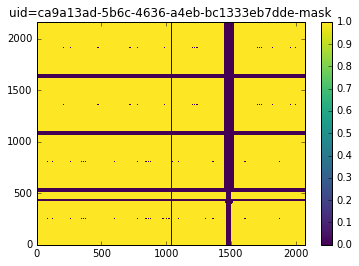

In [909]:
mask = load_mask(mask_path, mask_name, plot_ =  True, reverse=True, image_name = 'uid=%s-mask'%uid )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [910]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = None #NOTEBOOK_FULL_PATH
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
#md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [911]:
imgsa = apply_mask( imgs, mask )

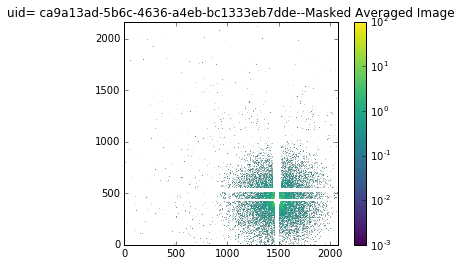

In [912]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

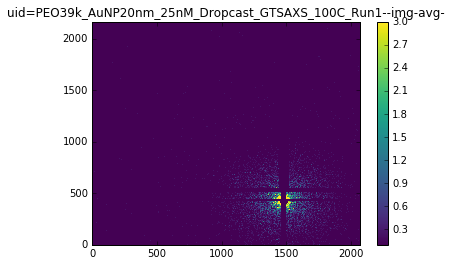

In [913]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=3.0, logs=False, image_name= 'uid=%s--img-avg-'%uid_,
        save=True, path=data_dir_) 
md['avg_img'] = avg_img

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


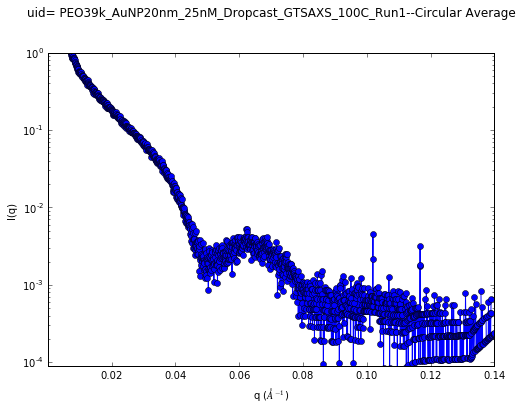

In [914]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
            plot_ = True, show_pixel= False, xlim=[0.0001,.14], ylim = [0.00009, 1e0], save=True)



### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [915]:
uniform = True

### Define a non-uniform distributed rings by giving edges

In [916]:
if not uniform:
    #width = 4  # in pixel
    width = 0.001    
    number_rings=1
    #centers = [ 31, 50, 67, 84, 102, 119] #in pixel
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    centers = [ 0.0065,0.0117,0.021,0.0336,0.044, 0.057] #in A-1
    edges = get_non_uniform_edges(  centers, width, number_rings )
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [917]:
if uniform:
    inner_radius= 0.0045
    outer_radius = 0.062
    width = 0.0035
    num_rings = 10
    edges = None

In [918]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, unit='A',
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 

In [919]:
md['center'] = center
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['data_dir'] = data_dir

psave_obj(  md, data_dir_ + 'uid=%s-md'%uid_ ) #save the setup parameters

In [920]:
#pload_obj(   data_dir + 'uid=%s-md'%uid_  )

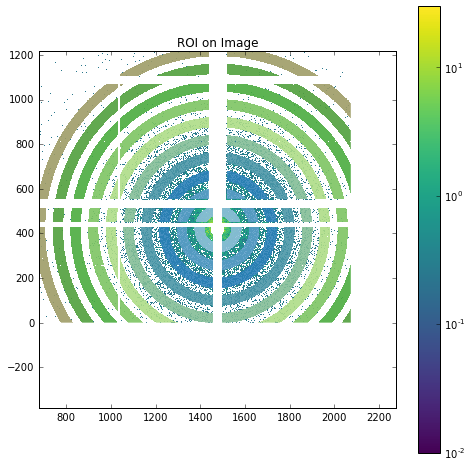

In [921]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=800, alpha=.9, 
                  vmax=30, save=True, path=data_dir_, uid=uid_)

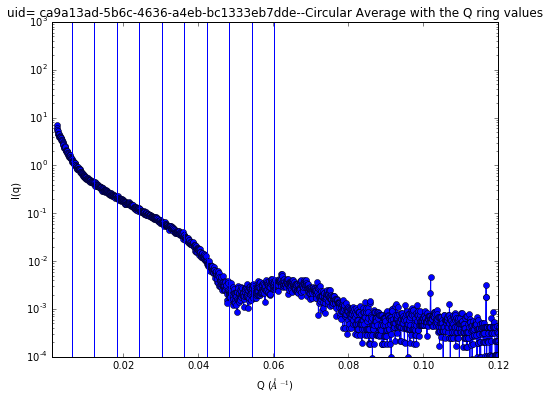

In [922]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.001,.12],
                  ylim = [1e-4, 1e3],        save=True, path=data_dir)

# Do loop here

In [923]:
run_num = 1
sub_num =  len(uids) //run_num
print( run_num, sub_num)

1 10


In [924]:
data_dir

'/XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/'

The 0--th uid to be analyzed is : ca9a13ad-5b6c-4636-a4eb-bc1333eb7dde
hdf5 path = /XF11ID/data/2016/11/12/79827283-6c9c-4571-aecb_1461_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_ca9a13ad-5b6c-4636-a4eb-bc1333eb7dde.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 1112.05it/s]


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:13<00:00,  7.83it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/ca9a13ad-5b6c-4636-a4eb-bc1333eb7dde/ with filename as uid=ca9a13ad-5b6c-4636-a4eb-bc1333eb7dde--g2.csv


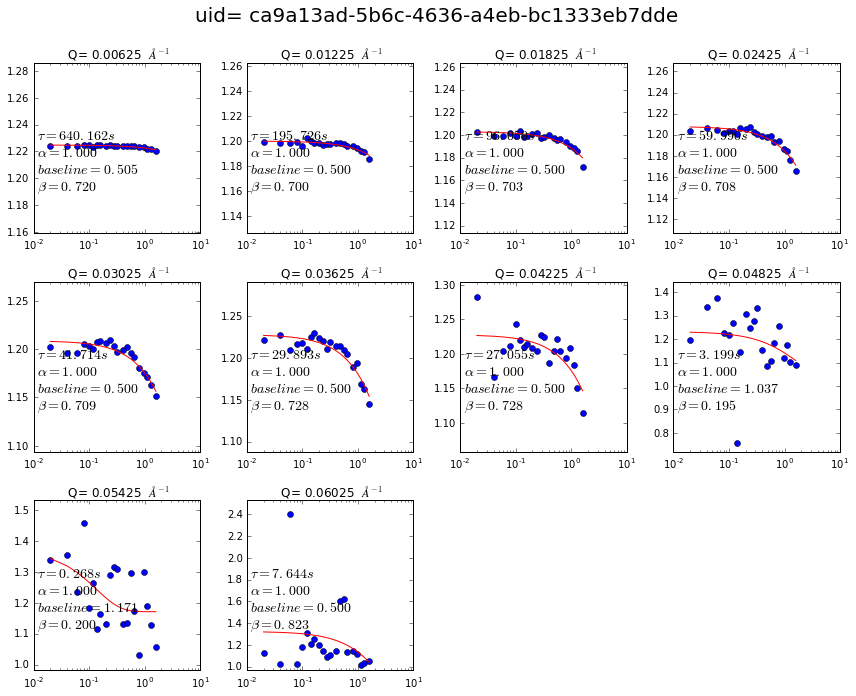

The fitted diffusion coefficient D0 is:  3.680e+02   A^2S-1


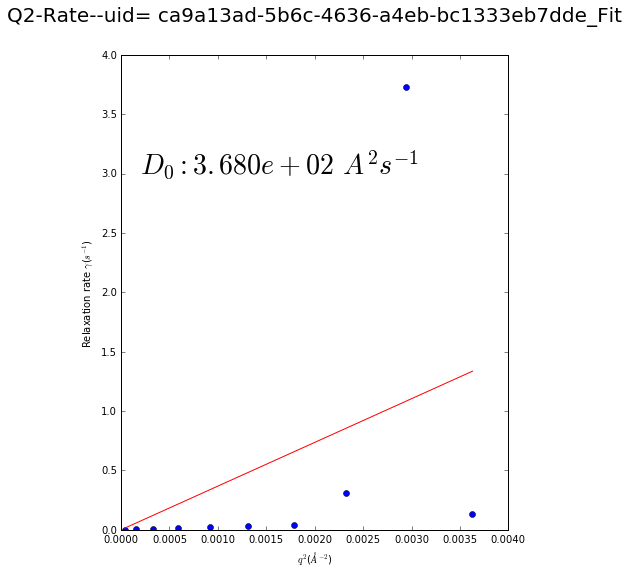

****************************************

The 1--th uid to be analyzed is : 04a0a507-4649-4884-8ed3-ad89d9ca2542
hdf5 path = /XF11ID/data/2016/11/12/1e7bff84-f8bc-4cdd-8647_1462_master.h5


Averaging images:  14%|█▎        | 15/110 [00:00<00:00, 139.32it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_04a0a507-4649-4884-8ed3-ad89d9ca2542.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 1001.72it/s]


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/04a0a507-4649-4884-8ed3-ad89d9ca2542/ with filename as uid=04a0a507-4649-4884-8ed3-ad89d9ca2542--g2.csv


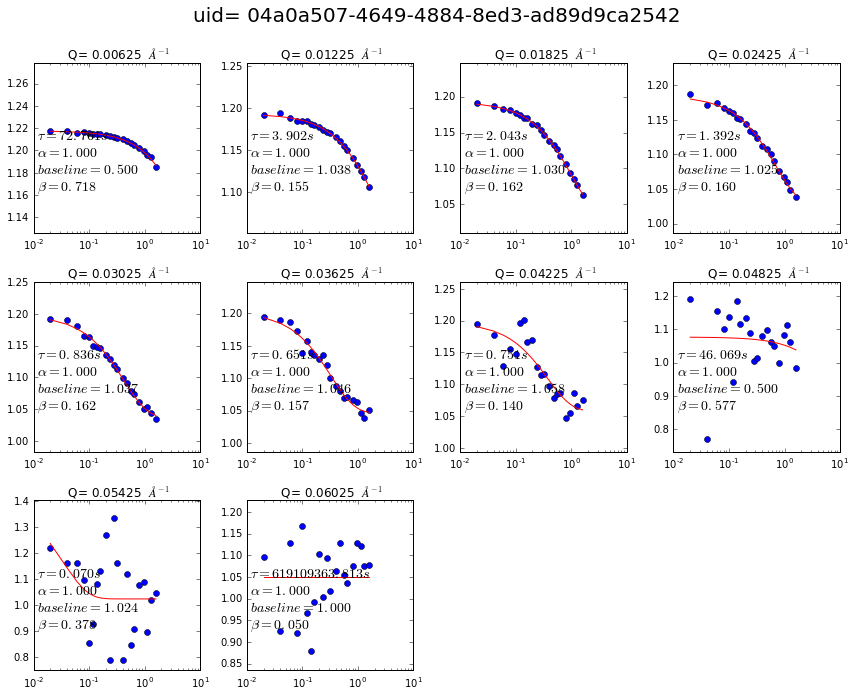

The fitted diffusion coefficient D0 is:  1.446e+03   A^2S-1


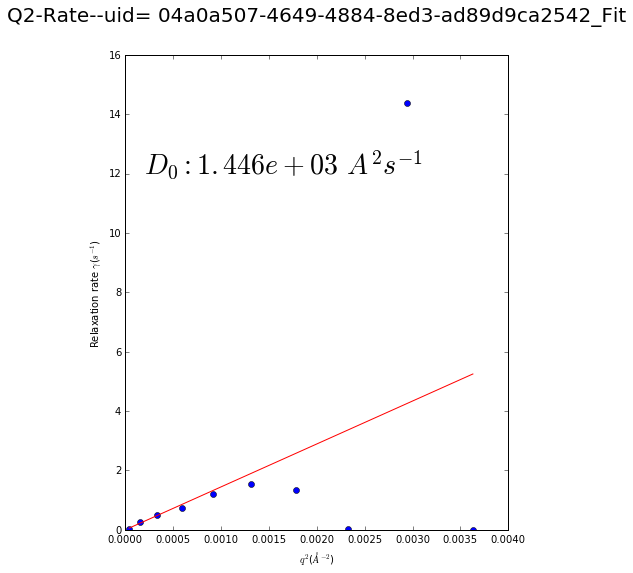

****************************************

The 2--th uid to be analyzed is : a827a7bd-75d8-46b8-98e2-10f5499688f2
hdf5 path = /XF11ID/data/2016/11/12/aa783328-ba06-4e45-b6b7_1463_master.h5


Averaging images:  13%|█▎        | 14/110 [00:00<00:00, 137.87it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_a827a7bd-75d8-46b8-98e2-10f5499688f2.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 1186.20it/s]


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:11<00:00,  7.79it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/a827a7bd-75d8-46b8-98e2-10f5499688f2/ with filename as uid=a827a7bd-75d8-46b8-98e2-10f5499688f2--g2.csv


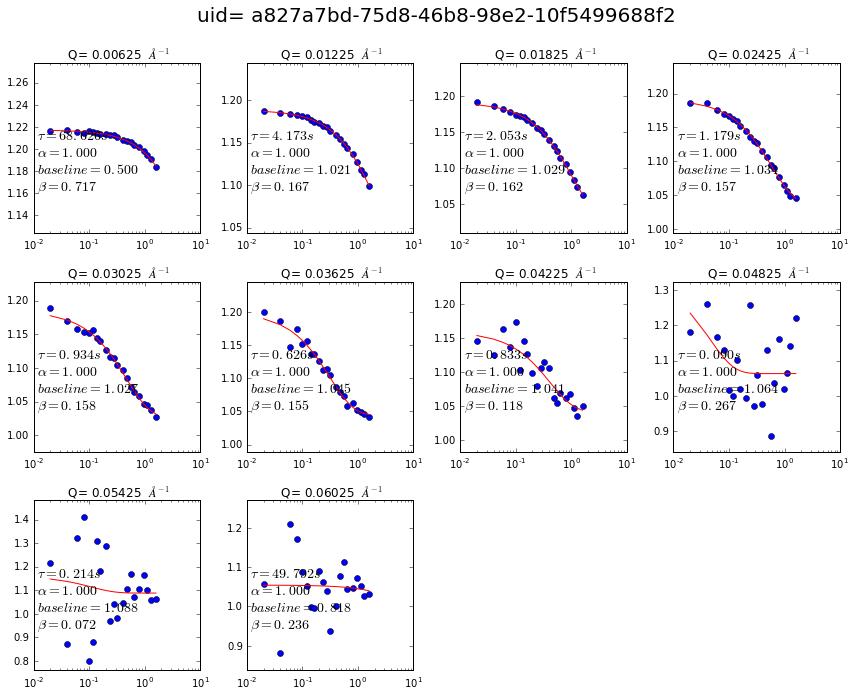

The fitted diffusion coefficient D0 is:  1.362e+03   A^2S-1


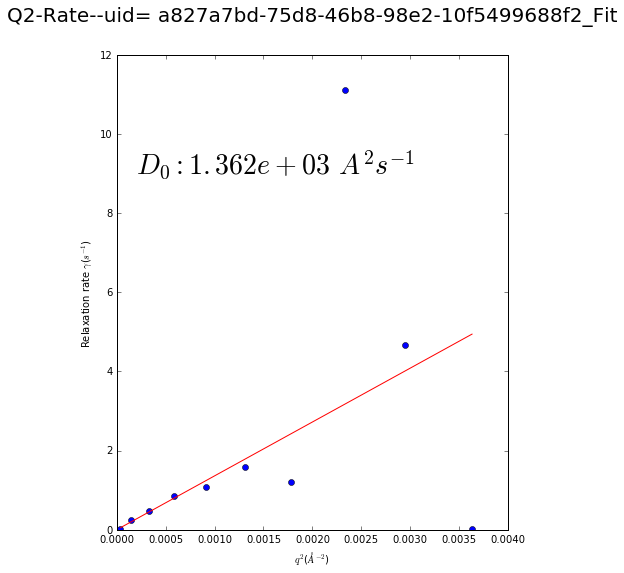

****************************************

The 3--th uid to be analyzed is : 05bfcd9b-64b8-4e71-94a8-98ec269c1ab5
hdf5 path = /XF11ID/data/2016/11/12/248b280d-58c7-477f-88f0_1464_master.h5


Averaging images:  12%|█▏        | 13/110 [00:00<00:00, 129.49it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_05bfcd9b-64b8-4e71-94a8-98ec269c1ab5.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 1186.15it/s]


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:13<00:00,  5.27it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/05bfcd9b-64b8-4e71-94a8-98ec269c1ab5/ with filename as uid=05bfcd9b-64b8-4e71-94a8-98ec269c1ab5--g2.csv


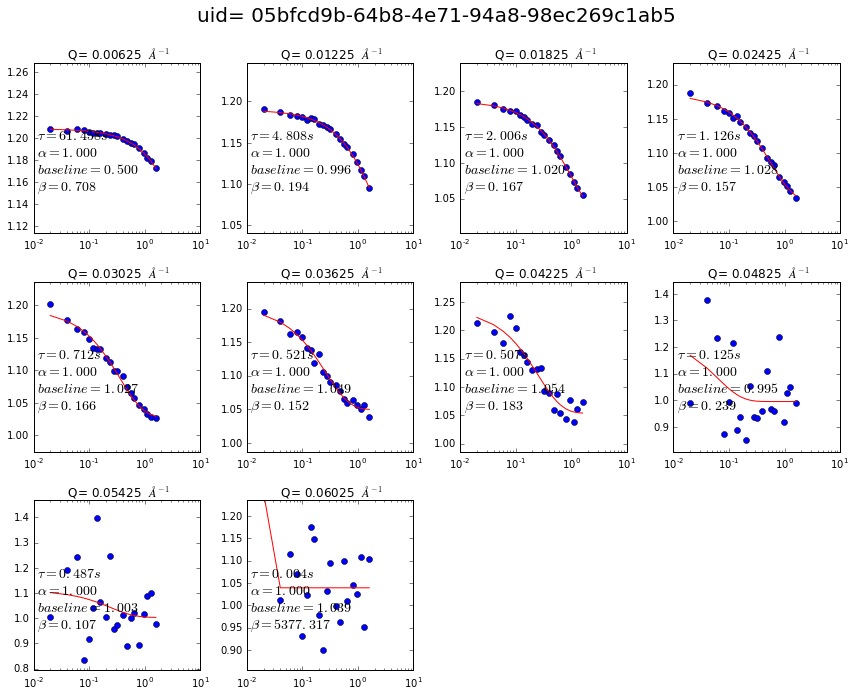

The fitted diffusion coefficient D0 is:  2.846e+04   A^2S-1


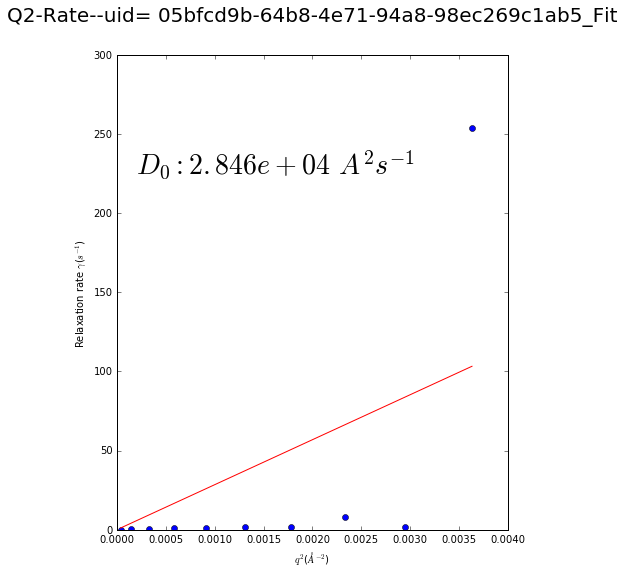

****************************************

The 4--th uid to be analyzed is : 2120a2b0-159a-4468-a10e-cc4086912ea0
hdf5 path = /XF11ID/data/2016/11/12/01b2649d-42c8-4141-bb76_1465_master.h5


Averaging images:  12%|█▏        | 13/110 [00:00<00:00, 124.52it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_2120a2b0-159a-4468-a10e-cc4086912ea0.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 897.69it/s] 


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 


  0%|          | 0/100 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:13<00:00,  7.80it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/2120a2b0-159a-4468-a10e-cc4086912ea0/ with filename as uid=2120a2b0-159a-4468-a10e-cc4086912ea0--g2.csv


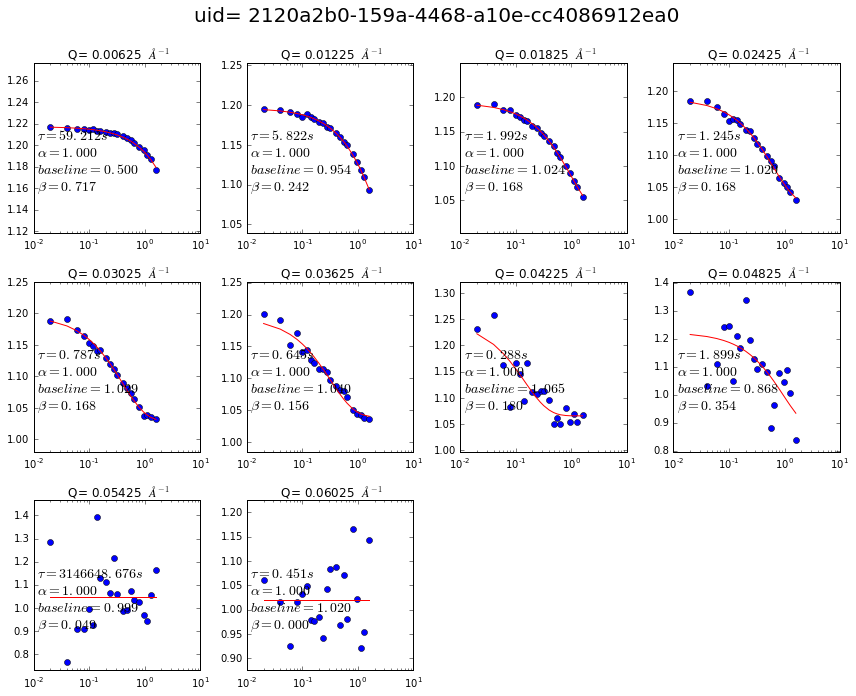

The fitted diffusion coefficient D0 is:  5.776e+02   A^2S-1


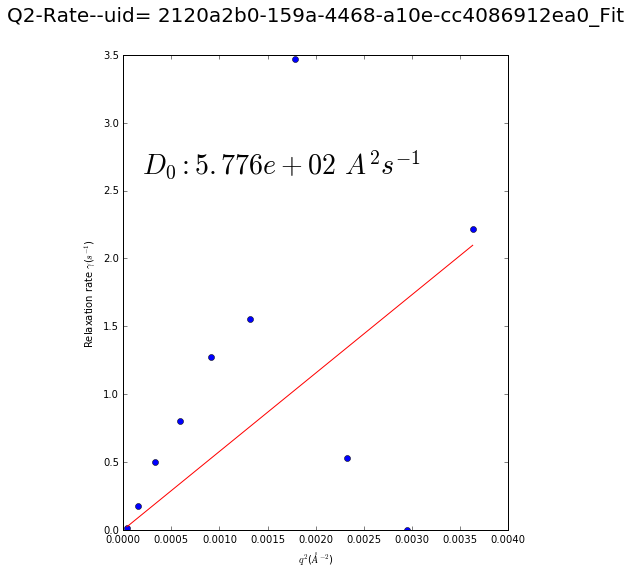

****************************************

The 5--th uid to be analyzed is : 77e36a33-94bc-4ad5-af29-85c29b9a617d
hdf5 path = /XF11ID/data/2016/11/12/e3a8f5db-6494-4a89-9174_1466_master.h5


Averaging images:  11%|█         | 12/110 [00:00<00:00, 117.46it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_77e36a33-94bc-4ad5-af29-85c29b9a617d.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 1209.19it/s]


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:12<00:00,  7.66it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/77e36a33-94bc-4ad5-af29-85c29b9a617d/ with filename as uid=77e36a33-94bc-4ad5-af29-85c29b9a617d--g2.csv


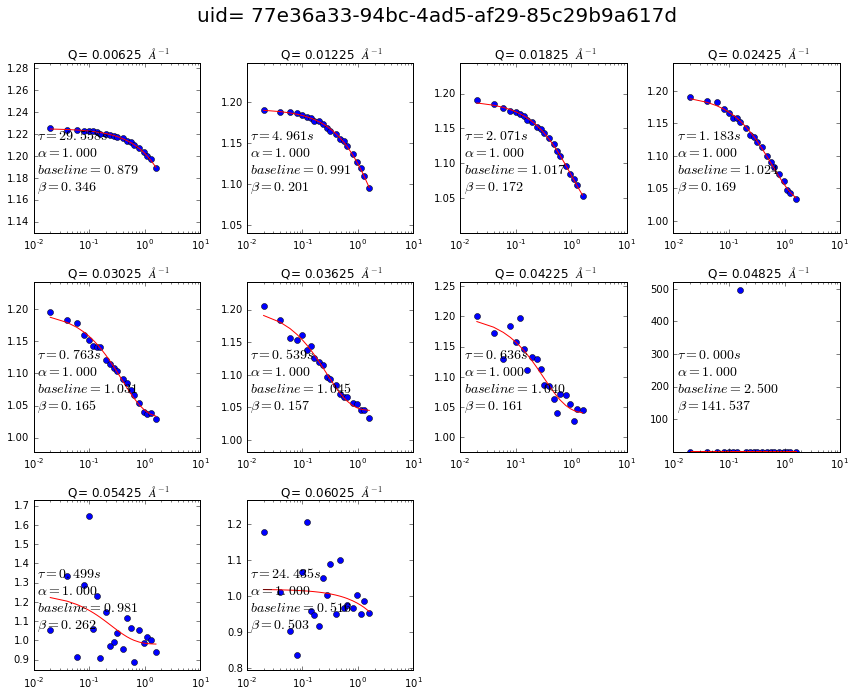

The fitted diffusion coefficient D0 is:  1.806e+05   A^2S-1


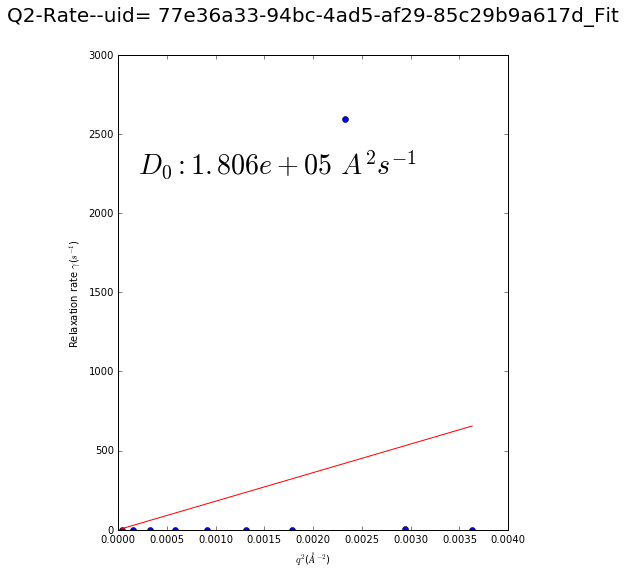

****************************************

The 6--th uid to be analyzed is : f36aa70a-6e7c-4134-98b9-c72e6928d06c
hdf5 path = /XF11ID/data/2016/11/12/170bccc0-9c86-4344-951e_1467_master.h5


Averaging images:  10%|█         | 11/110 [00:00<00:01, 98.13it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_f36aa70a-6e7c-4134-98b9-c72e6928d06c.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 1248.33it/s]


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/f36aa70a-6e7c-4134-98b9-c72e6928d06c/ with filename as uid=f36aa70a-6e7c-4134-98b9-c72e6928d06c--g2.csv


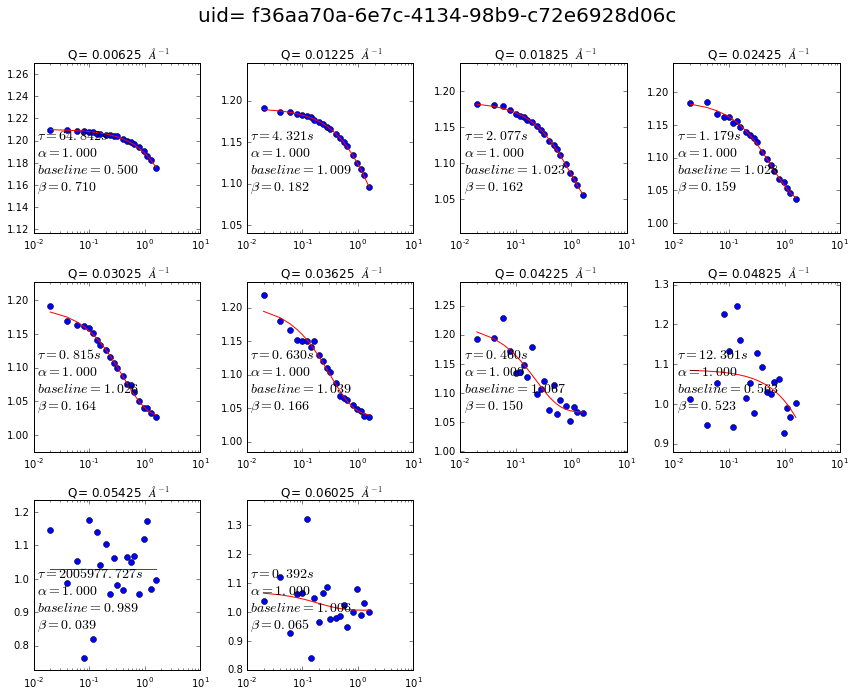

The fitted diffusion coefficient D0 is:  5.149e+02   A^2S-1


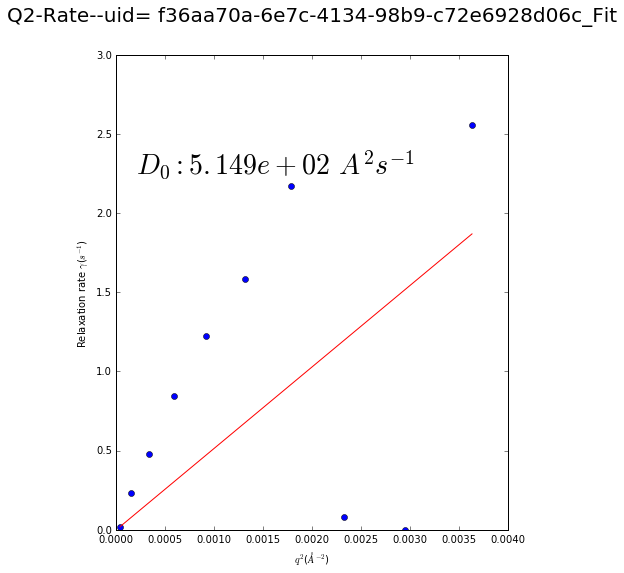

****************************************

The 7--th uid to be analyzed is : 0363a550-893c-4d80-90ed-07dcf94a7b97
hdf5 path = /XF11ID/data/2016/11/12/2f32a238-aa3b-4ffc-a1b6_1468_master.h5


Averaging images:  13%|█▎        | 14/110 [00:00<00:00, 121.23it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_0363a550-893c-4d80-90ed-07dcf94a7b97.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 911.82it/s]


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/0363a550-893c-4d80-90ed-07dcf94a7b97/ with filename as uid=0363a550-893c-4d80-90ed-07dcf94a7b97--g2.csv


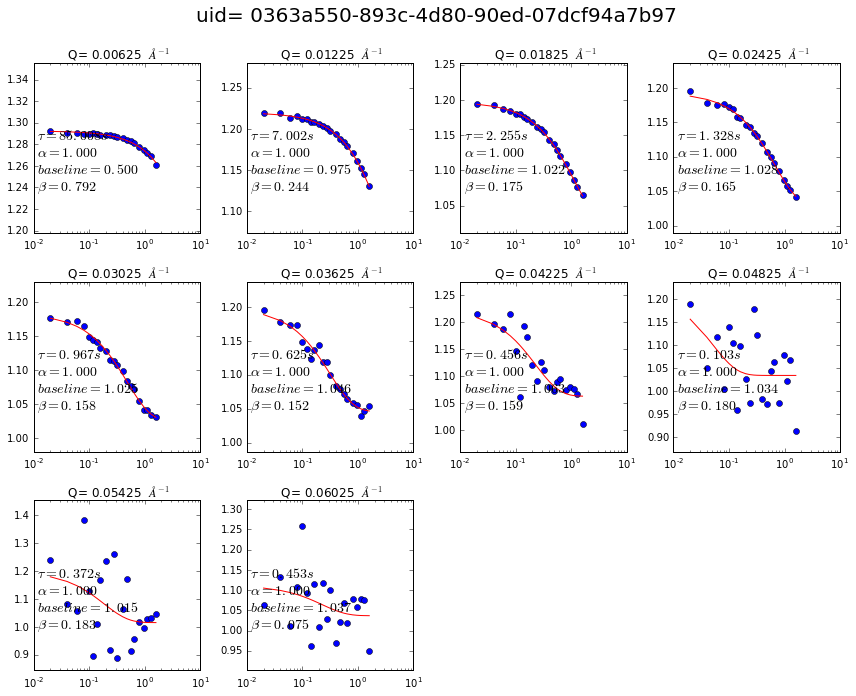

The fitted diffusion coefficient D0 is:  1.378e+03   A^2S-1


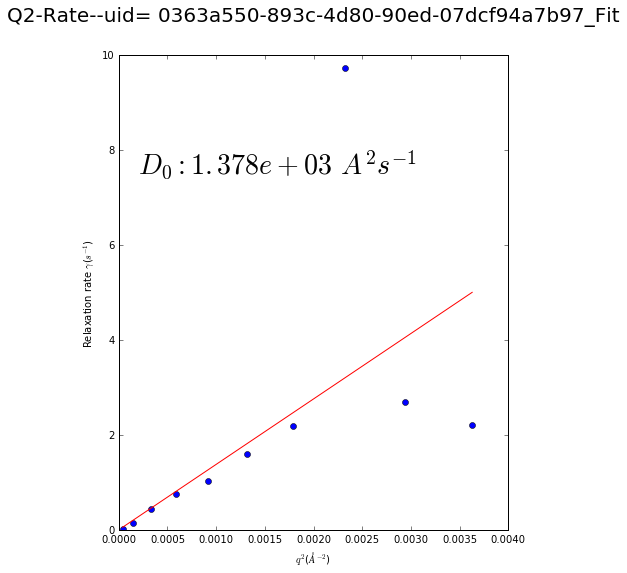

****************************************

The 8--th uid to be analyzed is : c103827e-9b7c-4080-990e-6172d5ac88a1
hdf5 path = /XF11ID/data/2016/11/12/b76dfdf3-794e-48e1-804a_1469_master.h5


Averaging images:  13%|█▎        | 14/110 [00:00<00:00, 137.59it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_c103827e-9b7c-4080-990e-6172d5ac88a1.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 1206.17it/s]


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:12<00:00,  7.91it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/c103827e-9b7c-4080-990e-6172d5ac88a1/ with filename as uid=c103827e-9b7c-4080-990e-6172d5ac88a1--g2.csv


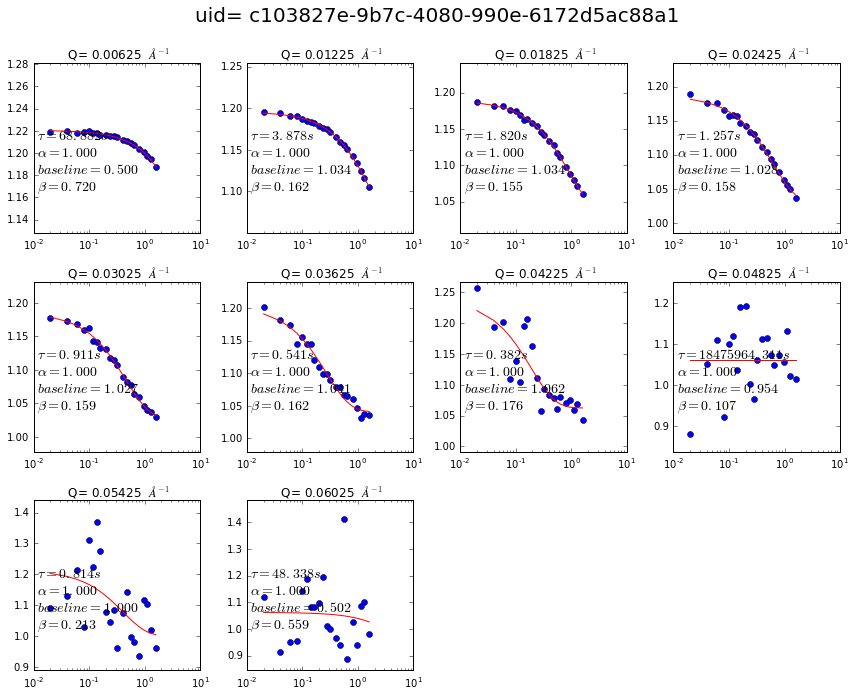

The fitted diffusion coefficient D0 is:  3.728e+02   A^2S-1


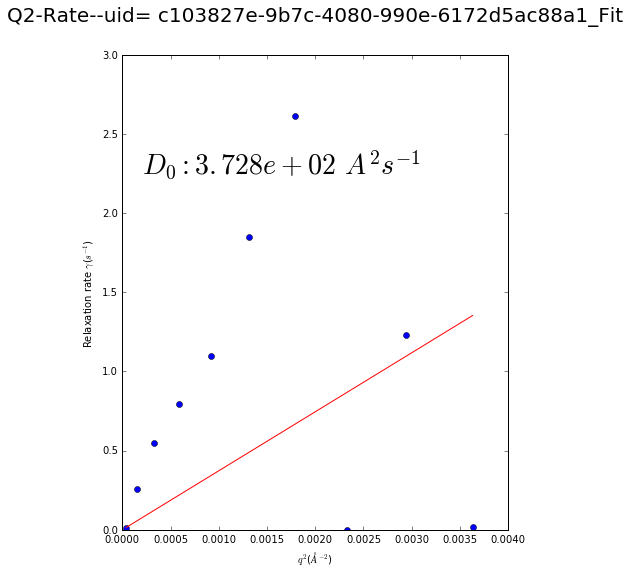

****************************************

The 9--th uid to be analyzed is : 084ba6c1-bf99-4c88-b847-289794995339
hdf5 path = /XF11ID/data/2016/11/12/5ef5d387-329a-4630-906a_1470_master.h5


Averaging images:   0%|          | 0/110 [00:00<?, ?it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_084ba6c1-bf99-4c88-b847-289794995339.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 1226.08it/s]


No bad frames are involved.
PEO39k_AuNP20nm_25nM_Dropcast 100C ; GT-XPCS
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:12<00:00,  7.47it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/084ba6c1-bf99-4c88-b847-289794995339/ with filename as uid=084ba6c1-bf99-4c88-b847-289794995339--g2.csv


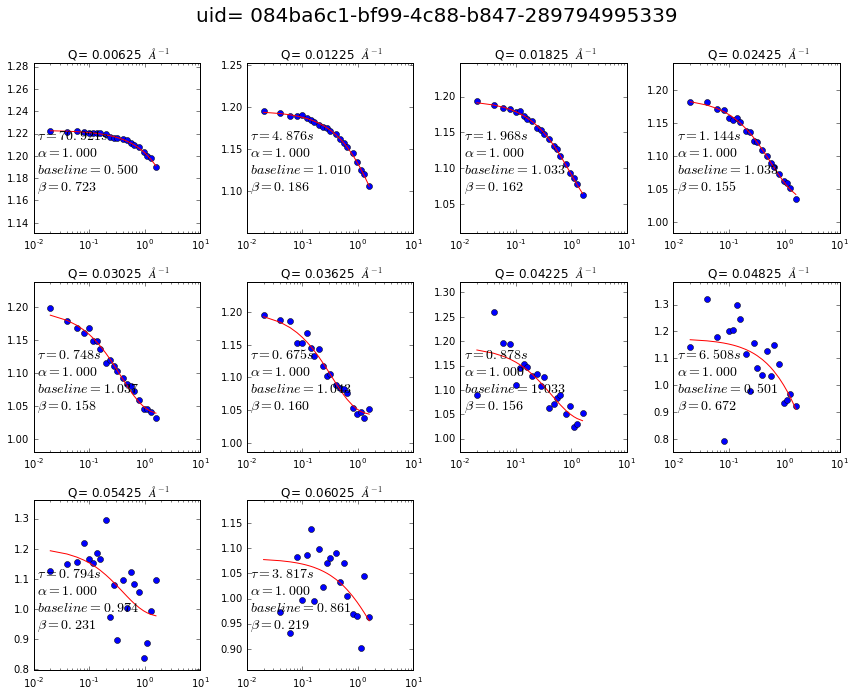

The fitted diffusion coefficient D0 is:  3.265e+02   A^2S-1


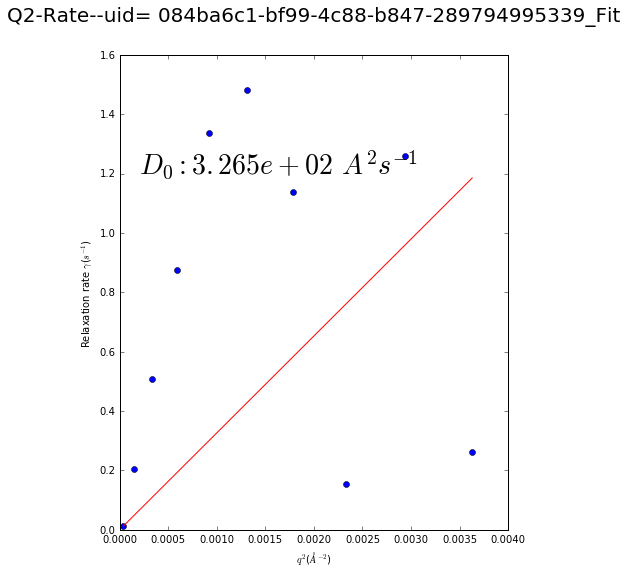

****************************************



In [925]:
g2s, taus, useful_uids  = multi_uids_saxs_xpcs_analysis(   uids, md, run_num, sub_num, 
                                    fit= True, force_compress= False,  compress= True  )


## Create PDF report for each uid

In [926]:
useful_uids

{1: {1: 'ca9a13ad-5b6c-4636-a4eb-bc1333eb7dde',
  2: '04a0a507-4649-4884-8ed3-ad89d9ca2542',
  3: 'a827a7bd-75d8-46b8-98e2-10f5499688f2',
  4: '05bfcd9b-64b8-4e71-94a8-98ec269c1ab5',
  5: '2120a2b0-159a-4468-a10e-cc4086912ea0',
  6: '77e36a33-94bc-4ad5-af29-85c29b9a617d',
  7: 'f36aa70a-6e7c-4134-98b9-c72e6928d06c',
  8: '0363a550-893c-4d80-90ed-07dcf94a7b97',
  9: 'c103827e-9b7c-4080-990e-6172d5ac88a1',
  10: '084ba6c1-bf99-4c88-b847-289794995339'}}

In [927]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

* Create multi PDF report for each uid

In [928]:
create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir, append_name='_1' )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/XPCS_Analysis_Report_for_uid=ca9a13ad-5b6c-4636-a4eb-bc1333eb7dde_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/XPCS_Analysis_Report_for_uid=04a0a507-4649-4884-8ed3-ad89d9ca2542_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM_Dropcast_GTSAXS_100C_Run1/XPCS_Analysis_Report_for_uid=a827a7bd-75d8-46b8-98e2-10f5499688f2_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/PEO39k_AuNP20nm_25nM

### Attach each g2 result to the corresponding olog entry

In [929]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [930]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [931]:
for key in list( useful_uids.keys()):
    for k in list( useful_uids[key]):
        uid_k = useful_uids[key][k]
        filename = data_dir + 'XPCS_Analysis_Report_for_uid=%s_1.pdf'%uid_k 
        atch=[  Attachment(open(filename, 'rb')) ] 
        update_olog_uid( uid=uid_k, text='Add XPCS Analysis PDF Report', attachments= atch )
     
    

HTTPError: 409 Client Error: Conflict for url: https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog/resources/attachments/35998

## Create one PDF including all uids

In [ ]:
create_one_pdf_reports_for_uids( useful_uids, g2s, data_dir, filename=uid_ )

# Do average Here

In [ ]:
list( g2s[1].keys() )

In [ ]:
bad_uids =[  ]

In [ ]:
g2s_average ={} # g2s[run] = g2 of each time series average

for key in list( g2s.keys()):
    g2s_average[key] = np.zeros_like( g2s[key][1])
    i=1
    for sub_key in list( g2s[key].keys() ):
        #print (g2s_average[key].shape, g2s[key][sub_key].shape  )        
        try:
            if sub_key not in bad_uids:
                g2s_average[key] +=  g2s[key][sub_key]
                i +=1
                print( 'Run= %s--sub_run= %s-- pass'%(key, sub_key) )
                #print( 'sub= %s,Doing average here'%sub_key)
            else:
                print( 'sub= %s,Can not Doing average here'%sub_key)
                
        except:            
            print( 'sub= %s,Can not Doing average here'%sub_key)
            pass
    g2s_average[key] /= i-1

# Save Data

In [ ]:
for key in list( g2s.keys()):
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s'%key )
    save_saxs_g2(    g2s_average[key], res_pargs )


# Plot All the g2 Data

In [ ]:
if False:
    for key in list( g2s.keys()):
        for sub_key in  list( g2s[key].keys()):
            res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s--subrun--%s'%(key, sub_key) )
            plot_saxs_g2( g2s[key][sub_key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 


# Plot Averaged Data

In [ ]:
if True:
    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s'%key )
        plot_saxs_g2( g2s_average[key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 

# Fit Averaged Data

In [ ]:
fit = True

In [ ]:
if fit:

    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                      path=data_dir_, uid=  uid_ + '@run--%s'%key )

        fit_result = fit_saxs_g2( g2s_average[key], res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
                    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                    guess_values={'baseline':1.45,'beta':0.08,'alpha':1.0,'relaxation_rate':0.01})
        
        #psave_obj( fit_result, data_dir + uid_ + '@run--%s'%key )
        
        fit_q_rate(  q_ring_center, fit_result['rate'], power_variable= False,
           uid=uid_ + '@run--%s'%key, path= data_dir_ )

        save_lists( [q_ring_center**2,fit_result['rate']], ['q2','rate'], 
                   filename= 'Q2-rate-uid=%s'%(uid_ + '@run--%s'%key), path= data_dir)

# Create a report for the avergae g2

In [ ]:
create_report = True

In [ ]:
#data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [ ]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
filename= "XPCS_Analysis_Report_for_uid=%s-average.pdf"%uid_
print (pdf_out_dir + filename)

In [ ]:
uid_

In [ ]:
if create_report:
    
    c= create_pdf_report(  data_dir_, uid_, pdf_out_dir,
                        filename= filename)
    page =1
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=page)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    Nk = len( list( g2s.keys()))
    Npages = Nk//2 + Nk%2
    
    for i, key in enumerate( list( g2s.keys())):        
        if not i%2:
            page += 1
            c.new_page()            
        
        c.report_header(page=page)
        if i%2:
            top = 350
        else:
            top = 720
            
        c.report_one_time( top= top, g2_fit_file =  'uid=%s@run--%s--g2--fit-.png'%(uid_,key  ),                     
                                 q_rate_file =  'uid=%s@run--%s--Q-Rate--fit-.png'%(uid_,key  ))
        
    c.save_page()
    c.done()  

# The End!

In [ ]:
last_uid_num = len( useful_uids[1] )

In [ ]:
uid_last = useful_uids[1][    last_uid_num     ]
print( uid_last )

In [ ]:
#uid_last = useful_uids[1][-1]

In [ ]:
c.filename

In [ ]:
#uid_ = uid_last  #useful_uids[key][k]
filename = c.filename  #XPCS_Analysis_Report_for_uid=%s.pdf'%uid_ 
atch=[  Attachment(open(filename, 'rb')) ] 
update_olog_uid( uid=uid_last, text='Add XPCS Analysis PDF Report', attachments= atch )